# Simple Time Series Example


how a simple time series simulation is performed with the timeseries and control module in pandapower. A time series calculation requires the minimum following inputs:
* pandapower net
* the time series (in a pandas Dataframe for example)

First we need some imports. Specific for this example are:
* ConstControl -> "constant" controllers, which change the P and Q values of sgens and loads
* DFData -> The Dataframe Datasource. This Dataframe holds the time series to be calculated
* OutputWriter -> The output writer, which is required to write the outputs to the hard disk
* run_timeseries -> the "main" time series function, which basically calls the controller functions (to update the P, Q of the ConstControllers) and runpp.

In [ ]:
import os
import numpy as np
import pandas as pd
import tempfile
import pandapower
import pandapower as pp
from pandapower.timeseries import DFData
from pandapower.timeseries import OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
import pandapower.networks as pn

import pandapower.plotting as plot

In [ ]:
!pip install pandapower


     |████████████████████████████████| 5.8MB 6.4MB/s 
     |████████████████████████████████| 153kB 46.2MB/s 
     |████████████████████████████████| 3.2MB 36.1MB/s 
  Created wheel for pandapower: filename=pandapower-2.6.0-cp37-none-any.whl size=5717285 sha256=30d5c131d9a350f352537ae51c38d3e24be9228c322a27e390133efe714c5055
  Stored in directory: /root/.cache/pip/wheels/dd/ae/7a/1838a2c545968cfe484a79a65386decaa5b2b84a07f948d5fe
Successfully built pandapower


In [ ]:
net = pn.case_ieee14()

In [ ]:
net

This pandapower network includes the following parameter tables:
   - bus (14 elements)
   - load (21 elements)
   - gen (5 elements)
   - shunt (2 elements)
   - ext_grid (1 element)
   - line (34 elements)
   - trafo (7 elements)
   - poly_cost (6 elements)
   - bus_geodata (30 elements)

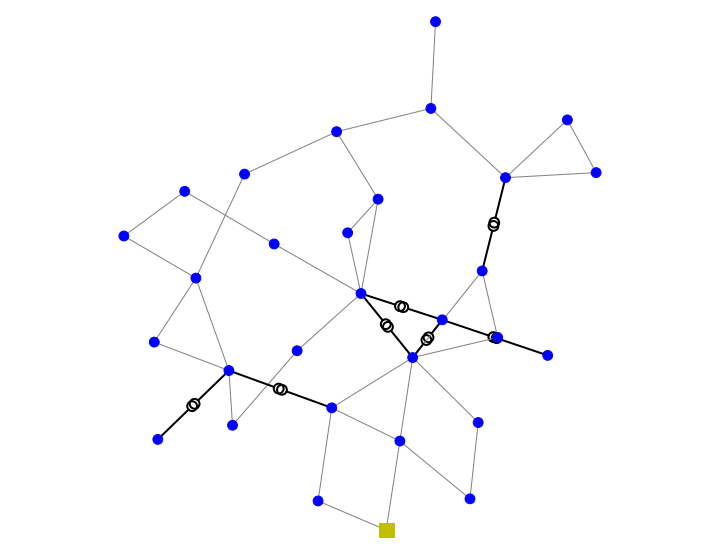

In [ ]:
# plot the grid to show the open ring systems
plot.simple_plot(net)

In [ ]:
from pandapower.networks import mv_oberrhein
from pandapower.plotting.plotly import pf_res_plotly
pandapower.runpp(net)
pf_res_plotly(net)

First we look at the time series example function. It follows these steps:
1. create a simple test net
2. create the datasource (which contains the time series P values)
3. create the controllers to update the P values of the load and the sgen
4. define the output writer and desired variables to be saved
5. call the main time series function to calculate the desired results

In [ ]:
def timeseries_example(output_dir):
    # 1. create test net
    # net = pn.case_ieee30()
    net = simple_test_net()

    # 2. create (random) data source
    n_timesteps = 24
    profiles, ds = create_data_source(n_timesteps)
    # # 3. create controllers (to control P values of the load and the sgen)
    create_controllers(net, ds)

    # # time steps to be calculated. Could also be a list with non-consecutive time steps
    time_steps = range(0, n_timesteps)

    # # 4. the output writer with the desired results to be stored to files.
    ow = create_output_writer(net, time_steps, output_dir=output_dir)

    # 5. the main time series function
    run_timeseries(net, time_steps)

We start by creating a simple example pandapower net consisting of five buses, a transformer, three lines, a load and a sgen. 

In [ ]:
def simple_test_net():
    """
    simple net that looks like:

    ext_grid b0---b1 trafo(110/20) b2----b3 load
                                    |
                                    |
                                    b4 sgen
    """
    net = pp.create_empty_network()
    pp.set_user_pf_options(net, init_vm_pu = "flat", init_va_degree = "dc", calculate_voltage_angles=True)

    b0 = pp.create_bus(net, 110)
    b1 = pp.create_bus(net, 110)
    b2 = pp.create_bus(net, 20)
    b3 = pp.create_bus(net, 20)
    b4 = pp.create_bus(net, 20)

    pp.create_ext_grid(net, b0)
    pp.create_line(net, b0, b1, 10, "149-AL1/24-ST1A 110.0")
    pp.create_transformer(net, b1, b2, "25 MVA 110/20 kV", name='tr1')
    pp.create_line(net, b2, b3, 10, "184-AL1/30-ST1A 20.0")
    pp.create_line(net, b2, b4, 10, "184-AL1/30-ST1A 20.0")

    pp.create_load(net, b2, p_mw=20., q_mvar=10., name='load1')
    pp.create_sgen(net, b4, p_mw=20., q_mvar=0.15, name='sgen1')

    return net

The data source is a simple pandas DataFrame. It contains random values for the load and the sgen P values ("profiles"). Of course your time series values should be loaded from a file later on.
Note that the profiles are identified by their column name ("load1_p", "sgen1_p"). You can choose here whatever you prefer.
The DFData(profiles) converts the Dataframe to the required format for the controllers. Note that the controller

In [ ]:
def create_data_source(n_timesteps=24):
    profiles = pd.DataFrame()
    profiles['load1_p'] = np.random.random(n_timesteps) * 20.
    profiles['sgen1_p'] = np.random.random(n_timesteps) * 20.

    ds = DFData(profiles)

    return profiles, ds

create the controllers by telling the function which element_index belongs to which profile. In this case we map:
* first load in dataframe (element_index=[0]) to the profile_name "load1_p"
* first sgen in dataframe (element_index=[0]) to the profile_name "sgen1_p"

In [ ]:
def create_controllers(net, ds):
    ConstControl(net, element='load', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["load1_p"])
    ConstControl(net, element='sgen', variable='p_mw', element_index=[0],
                 data_source=ds, profile_name=["sgen1_p"])

create the output writer. Instead of saving the whole net (which takes a lot of time), we extract only pre defined outputs.
In this case we:
* save the results to "../timeseries/tests/outputs" 
* write the results to ".xls" Excel files. (Possible are: .json, .p, .csv)
* log the variables "p_mw" from "res_load", "vm_pu" from "res_bus" and two res_line values.

In [ ]:
def create_output_writer(net, time_steps, output_dir):
    ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".xls", log_variables=list())
    # these variables are saved to the harddisk after / during the time series loop
    ow.log_variable('res_load', 'p_mw')
    ow.log_variable('res_bus', 'vm_pu')
    ow.log_variable('res_line', 'loading_percent')
    ow.log_variable('res_line', 'i_ka')
    return ow

Now lets execute the code.

In [ ]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: /tmp/time_series_example
Progress: |██████████████████████████████████████████████████| 100.0% Complete



If everything works you should have the desired results the output_folder, which is the temporary folder of your operating system (see print statement above).

## Plot the result
Let's read the result from the disk and plot it

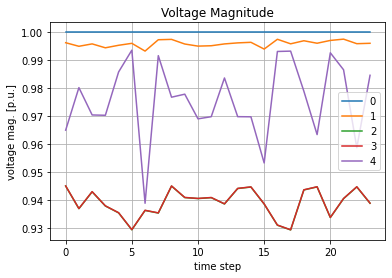

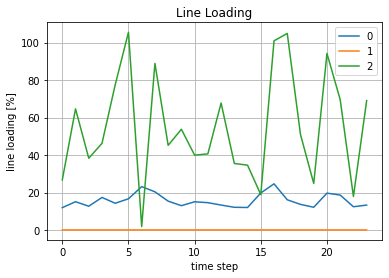

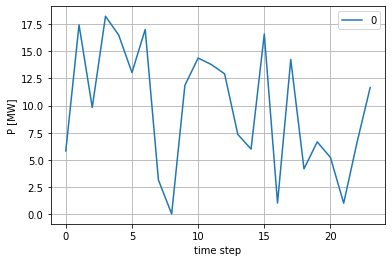

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xls")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xls")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xls")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()

In [ ]:
network_model=net
print('Number of load buses: ',net.load.shape[0])
print('Which buses are they on: ',net.load.bus.values)

Number of load buses:  21
Which buses are they on:  [ 1  2 15 16 17 18 19 20 22 23 25 28  3 29  4  6  7  9 11 13 14]


In [ ]:
#Look at powerflows to begin with
pp.runpp(net, enforce_q_lims=True)

In [ ]:
net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source


In [ ]:
net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.060000,0.000000,-262.45507,-42.928976
1,1.020792,-5.111640,-18.30000,-27.300000
10,0.997822,-14.180143,0.00000,-6.000000
11,0.996999,-15.228561,11.20000,7.500000
12,1.005354,-15.228561,0.00000,-6.000000
13,0.980832,-16.224743,6.20000,1.600000
14,0.975635,-16.310747,8.20000,2.500000
15,0.982088,-15.834747,3.50000,1.800000
16,0.975944,-16.180688,9.00000,5.800000
17,0.964530,-16.981483,3.20000,0.900000


In [ ]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,174.806382,18.427519,-169.506566,-8.272897,5.299816,10.154621,0.725298,0.727163,0.727163,1.060000,0.000000,1.020792,-5.111640,0.000727
1,87.648688,24.501457,-84.269473,-16.437671,3.379215,8.063786,0.375529,0.379775,0.379775,1.060000,0.000000,0.988823,-7.272551,0.000380
10,7.878415,2.566614,-7.793389,-2.389861,0.085026,0.176752,0.145403,0.145403,0.145403,0.996999,-15.228561,0.980832,-16.224743,0.000145
11,17.848332,7.406507,-17.599637,-6.916632,0.248694,0.489875,0.339101,0.339101,0.339101,0.996999,-15.228561,0.975635,-16.310747,0.000339
12,7.164303,4.102018,-7.099510,-3.965780,0.064794,0.136238,0.144869,0.144869,0.144869,0.996999,-15.228561,0.982088,-15.834747,0.000145
13,1.593389,0.789861,-1.586124,-0.783296,0.007266,0.006565,0.031722,0.031722,0.031722,0.980832,-16.224743,0.975635,-16.310747,0.000032
14,3.599510,2.165780,-3.589922,-2.130596,0.009587,0.035184,0.074836,0.074836,0.074836,0.982088,-15.834747,0.975944,-16.180688,0.000075
15,6.035567,2.024022,-5.989885,-1.930998,0.045682,0.093024,0.114156,0.114156,0.114156,0.975635,-16.310747,0.964530,-16.981483,0.000114
16,2.789885,1.030998,-2.783809,-1.018712,0.006076,0.012286,0.053950,0.053950,0.053950,0.964530,-16.981483,0.961305,-17.163511,0.000054
17,-6.716191,-2.381288,6.734873,2.418653,0.018682,0.037365,0.129688,0.129688,0.129688,0.961305,-17.163511,0.965373,-16.931530,0.000130


#Fake/False test data

In [ ]:
#Fake/False test data

num_times = 24
p_load_data = np.random.randn(net.load.shape[0],num_times)
q_load_data = np.random.randn(net.load.shape[0],num_times)

In [ ]:
def update_loads(self, new_p=None, new_q=None):

        """Update the loads in the network.
        This method assumes that the orders match, i.e. the order the buses in
        self.net.load.bus matches where the loads in new_p and new_q should be
        applied based on their indexing.
        Parameters
        ----------
        new_p, new_q: array_like
            New values for the real and reactive load powers, shape (number of load buses, 1).
        Attributes
        ----------
        self.net.load: object
            The load values in the network object are updated.
        """
        if new_p is not None:
            net.load.p_kw = new_p
        if new_q is not None:
            net.load.q_kvar = new_q

### **Update loads and run a powerflow**

In [ ]:
update_loads(p_load_data[:,0],q_load_data[:,0])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



In [ ]:
#runinng the power flow again


pp.runpp(net, enforce_q_lims=True,
                     calculate_voltage_angles=False,
                     voltage_depend_loads=False)

In [ ]:
net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,174.806382,18.427519,-169.506566,-8.272897,5.299816,10.154621,0.725298,0.727163,0.727163,1.060000,0.000000,1.020792,-5.111640,0.000727
1,87.648688,24.501457,-84.269473,-16.437671,3.379215,8.063786,0.375529,0.379775,0.379775,1.060000,0.000000,0.988823,-7.272551,0.000380
10,7.878415,2.566614,-7.793389,-2.389861,0.085026,0.176752,0.145403,0.145403,0.145403,0.996999,-15.228561,0.980832,-16.224743,0.000145
11,17.848332,7.406507,-17.599637,-6.916632,0.248694,0.489875,0.339101,0.339101,0.339101,0.996999,-15.228561,0.975635,-16.310747,0.000339
12,7.164303,4.102018,-7.099510,-3.965780,0.064794,0.136238,0.144869,0.144869,0.144869,0.996999,-15.228561,0.982088,-15.834747,0.000145
13,1.593389,0.789861,-1.586124,-0.783296,0.007266,0.006565,0.031722,0.031722,0.031722,0.980832,-16.224743,0.975635,-16.310747,0.000032
14,3.599510,2.165780,-3.589922,-2.130596,0.009587,0.035184,0.074836,0.074836,0.074836,0.982088,-15.834747,0.975944,-16.180688,0.000075
15,6.035567,2.024022,-5.989885,-1.930998,0.045682,0.093024,0.114156,0.114156,0.114156,0.975635,-16.310747,0.964530,-16.981483,0.000114
16,2.789885,1.030998,-2.783809,-1.018712,0.006076,0.012286,0.053950,0.053950,0.053950,0.964530,-16.981483,0.961305,-17.163511,0.000054
17,-6.716191,-2.381288,6.734873,2.418653,0.018682,0.037365,0.129688,0.129688,0.129688,0.961305,-17.163511,0.965373,-16.931530,0.000130


In [ ]:
output_dir = os.path.join(tempfile.gettempdir(), "time_series_example")
print("Results can be found in your local temp folder: {}".format(output_dir))
if not os.path.exists(output_dir):
    os.mkdir(output_dir)
timeseries_example(output_dir)

Results can be found in your local temp folder: /tmp/time_series_example
Progress: |██████████████████████████████████████████████████| 100.0% Complete



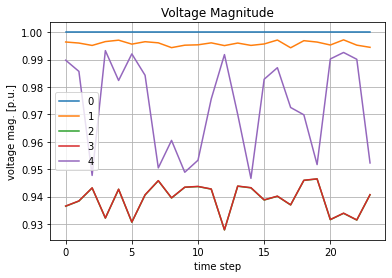

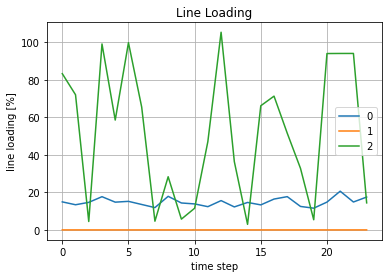

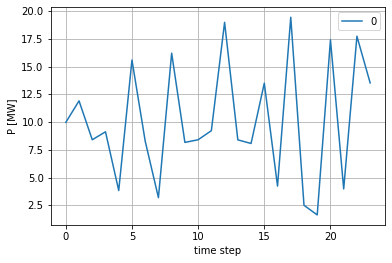

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline  

# voltage results
vm_pu_file = os.path.join(output_dir, "res_bus", "vm_pu.xls")
vm_pu = pd.read_excel(vm_pu_file, index_col=0)
vm_pu.plot(label="vm_pu")
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()
plt.show()

# line loading results
ll_file = os.path.join(output_dir, "res_line", "loading_percent.xls")
line_loading = pd.read_excel(ll_file, index_col=0)
line_loading.plot(label="line_loading")
plt.xlabel("time step")
plt.ylabel("line loading [%]")
plt.title("Line Loading")
plt.grid()
plt.show()

# load results
load_file = os.path.join(output_dir, "res_load", "p_mw.xls")
load = pd.read_excel(load_file, index_col=0)
load.plot(label="load")
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.grid()
plt.show()